<a href="https://colab.research.google.com/github/jiananwu72/LuFeO3Detect/blob/main/LuFeO3/LFOWindowing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyNSID sidpy atomap nanonispy gwyfile pyTEMlib wget ipympl importlib
!pip install numpy==1.26.4

In [2]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


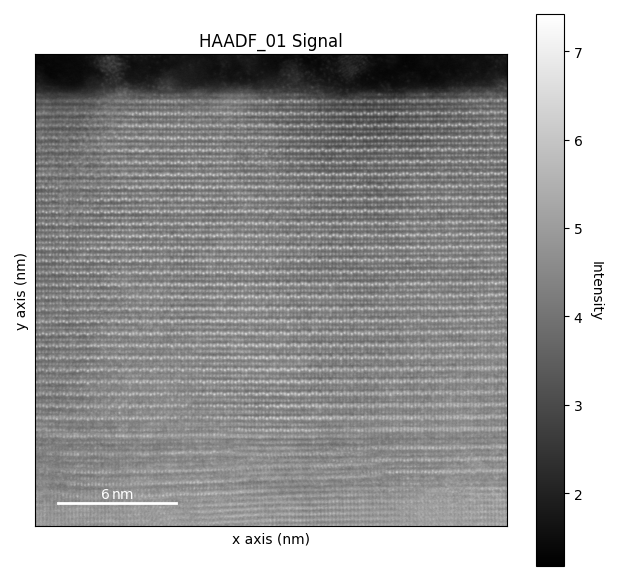

In [3]:
import hyperspy.api as hs
s = hs.load('/content/drive/MyDrive/Data/LFO/HAADF_01.dm3')
s.plot();

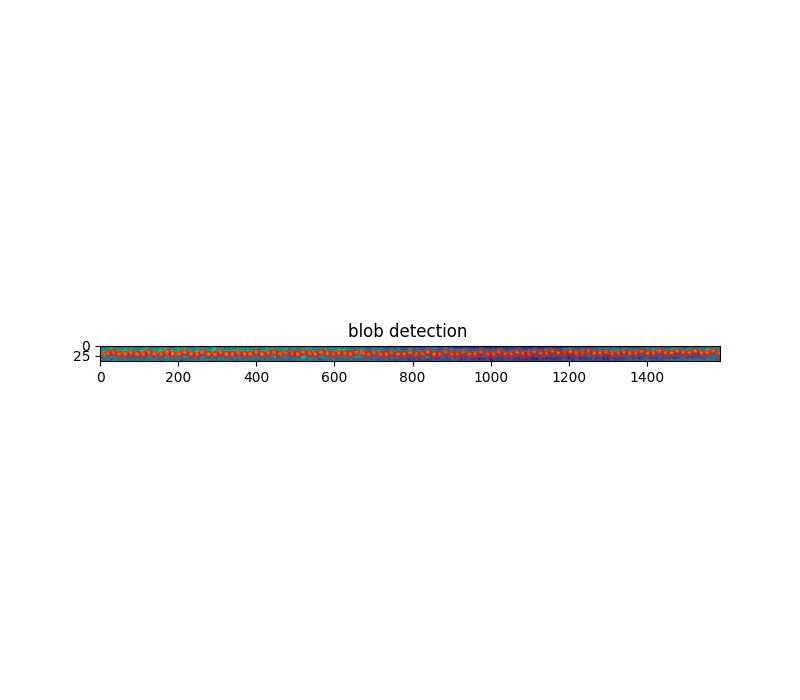

In [4]:
import skimage
# ------- Input ------
threshold = 0.4 #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = 0.1 #in nm
min_atom_size = 0.06 #in nm
# ----------------------

s_cropped = s.isig[360:-100, 295:335]
image = s_cropped

scale_x =image.axes_manager['x'].scale
blobs = skimage.feature.blob_log(image, min_sigma = min_atom_size/scale_x, max_sigma=atom_size/scale_x, threshold=threshold)

fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image, interpolation='nearest', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 1], blobs[:, 0], c='r', s=20, alpha = .5);

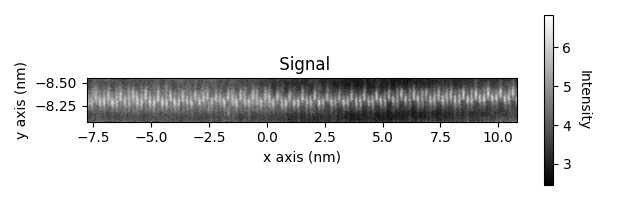

In [74]:
image.plot();

In [38]:
import pyTEMlib.atom_tools
atom_radius = 3

sym = pyTEMlib.atom_tools.atom_refine(np.array(s_cropped), blobs, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

using radius  3 pixels


  0%|          | 0/106 [00:00<?, ?it/s]

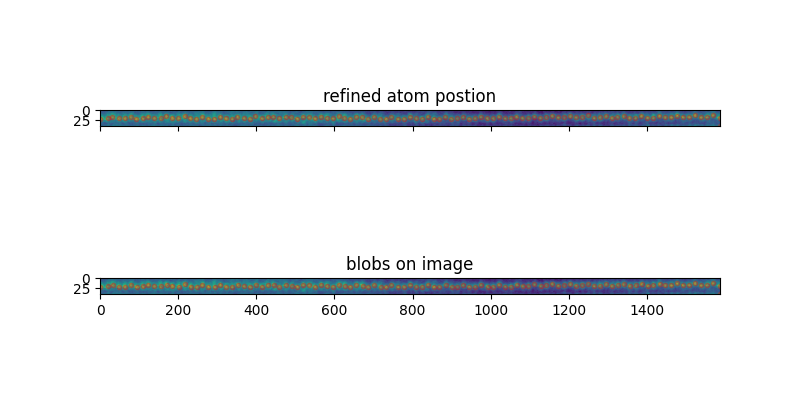

In [40]:
fig, ax = plt.subplots(2, 1, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,1],refined_atoms[:,0],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(blobs[:, 1], blobs[:, 0], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');

In [67]:
atoms = refined_atoms[refined_atoms[:, 1].argsort()]
atoms = atoms[:-1] #temporary fix

imagearr = np.array(image)
H, W = imagearr.shape

radius = 2

# Prepare a list to collect all 3×3 patches and keep track of valid indices
patches = []
valid_indices = []

for idx in range(atoms.shape[0]):
    y, x = atoms[idx]
    cx = int(round(x))
    cy = int(round(y))

    if (cx - radius < 0) or (cy - radius < 0) or (cx + radius >= W) or (cy + radius >= H):
        continue

    patch = imagearr[cy - radius : cy + radius + 1,
                     cx - radius : cx + radius + 1]

    patches.append(patch)
    valid_indices.append(idx)

# Convert the list of patches into a single NumPy array of shape (N_valid, 3, 3)
if len(patches) > 0:
    patches_array = np.stack(patches)
else:
    patches_array = np.empty((0, radius*2 + 1, radius*2 + 1))

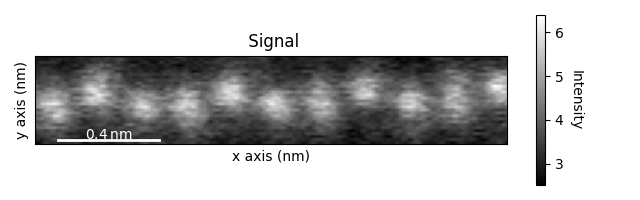

In [41]:
windows = []
image = s_cropped
radius_x = 80
radius_y = 15
atoms = refined_atoms
for i in range(atoms.shape[0]):
    x = int(atoms[i][1])
    y = int(atoms[i][0])
    if x > radius_x and x < image.data.shape[1]-radius_x and y > radius_y and y < image.data.shape[0]-radius_y:
        window = image.isig[x - radius_x:x + radius_x, y - radius_y:y + radius_y]
        windows.append(window)

windows[3].plot();

In [72]:
patches_array.shape

(103, 5, 5)

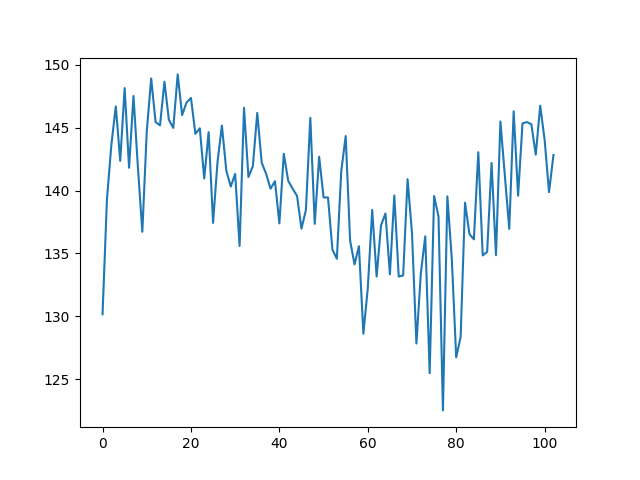

In [73]:
sums = []
for i in range(len(patches_array)):
    sums.append(np.sum(np.array(patches_array[i])))

plt.figure()
# plt.hist(sums, bins=20);
plt.plot(sums);

In [43]:
len(windows)

80